# Training with Keras


**In this notebook:**
* training feedforward neural network
* test model on test data set
* save prediction in Kaggle submission format

**Key insights:**
* reaching logloss of 1.95 
* weighting submission improves results

## Imports

In [4]:
%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../utils/')
from evaluation import Evaluation
from keras.models import Sequential
from keras.layers import Dense
from keras_models import baseline_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [5]:
data_path = "../../data/msk-redefining-cancer-treatment"
x_train = np.load(os.path.join(data_path, "processed/x_train_shuffled.npy"))
y_train = np.load(os.path.join(data_path, "processed/y_train_shuffled.npy"))
x_test = np.load(os.path.join(data_path, "processed/x_test_shuffled.npy"))
y_test = np.load(os.path.join(data_path, "processed/y_test_shuffled.npy"))
print("Training Data Shape:".ljust(20), x_train.shape)
print("Test Data Shape:".ljust(20), x_test.shape)

Training Data Shape: (3683, 111)
Test Data Shape:     (125, 111)


## Prepare Data

Training Data Shape after Oversampling: (9447, 111)


<BarContainer object of 9 artists>

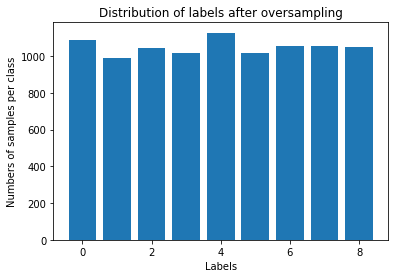

In [6]:
#Oversampling
x_train, y_train = ADASYN(sampling_strategy='auto').fit_sample(x_train,y_train)
print("Training Data Shape after Oversampling:", x_train.shape)
plt.title('Distribution of labels after oversampling')
plt.xlabel('Labels')
plt.ylabel('Numbers of samples per class')
plt.bar(np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1])

In [7]:
# label -> one-hot encoding
encoder = OneHotEncoder()
y_train = y_train - 1  # new labels 0,1,...8
y_train = encoder.fit_transform((y_train.reshape(-1, 1)))
print('Labels: ', encoder.categories_[0])
y_test = y_test - 1
y_test = encoder.transform((y_test.reshape(-1, 1)))

Labels:  [-1  0  1  2  3  4  5  6  7]


## Training the Model and Predicting the Ytest

In [8]:
modeltime = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")

model = baseline_model()
model.summary()


estimator=model.fit(X_resampled,Y_train_cateogorial, epochs=12, batch_size=64, validation_split=0.05)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                1332      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 117       
Total params: 1,605
Trainable params: 1,605
Non-trainable params: 0
_________________________________________________________________


NameError: name 'X_resampled' is not defined

In [108]:
model.model.save('models/keras_'+modeltime+'.h5')
pred = model.predict_proba(X_test)

In [110]:
modeltime

'18-06-04-15-38'

In [109]:
# Transform into submission format
submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = np.arange(1,987)
# Save submission without weighting
submission.to_csv('submissions/submission_keras_' + modeltime +'.csv', index=False)

# Weighting Predictions

Inspired by another notebook we weighted our results. 

In [111]:
all_1_over_9 = pd.read_csv(os.path.join(data_path, "external/submission_1_over_9.csv"))
all_1_over_9 = all_1_over_9.drop("ID", axis=1)

# weighted average
weighting = (6, 4)
submission_wighted = (preds_proba * weighting[0] + all_1_over_9 * weighting[1]) / 10
print(submission_wighted.shape)

(986, 9)


# Private Leaderbord Evaluation 

In [112]:
print(submission_wighted)
ids = pd.read_csv(os.path.join(data_path, "raw/stage_2_private_solution.csv")).ID.tolist()
pred = np.take(submission_wighted,(list(ids-1)), axis =0)  

[[0.08330638 0.16833387 0.11551378 ... 0.20163858 0.0788776  0.06191207]
 [0.44638036 0.05083759 0.04991878 ... 0.05253161 0.04446169 0.07124815]
 [0.17557488 0.12543616 0.08447638 ... 0.11200498 0.04524772 0.05075913]
 ...
 [0.06188082 0.13053432 0.10330038 ... 0.19086217 0.16039777 0.06538364]
 [0.1962643  0.08502063 0.1009356  ... 0.08546484 0.04469169 0.04820848]
 [0.07385273 0.19659456 0.07601938 ... 0.23755963 0.09965902 0.06866971]]


/home/ramona/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.28 Log loss: 1.9599735417729978 F1 micro: 0.28 F1 macro: 0.13984237507202857


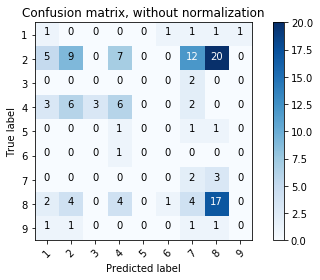

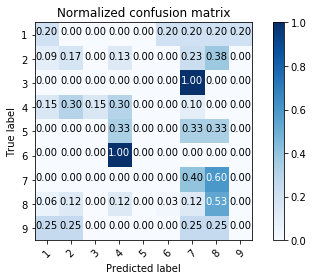

one row with the evaluation data is appended at /mnt/4_TB_HD/ramona/develop/results.csv


In [113]:
ev = Evaluation(y_pred=submission_wighted, y_test=y_test)
ev.entire_evaluation()

# Save Submission

In [ ]:
# transform weighted average into kaggle format
submission_wighted = pd.DataFrame(
    submission_wighted, columns=["class" + str(c + 1) for c in range(9)]
)
submission_wighted["ID"] = np.arange(1, 987)

# save submission
submission_wighted.to_csv(
    "submissions/submission_catboost_wighted"
    + str(weighting)
    + "_"
    + modeltime
    + ".csv",
    index=False,
)